# Wrapping an Application Package using EOEPCA's cwl-wrapper

This notebook uses the Python kernel.

In [1]:
from cwl_wrapper.app import main as cwl_wrapper_main
from cwltool.main import main as cwltool_main
import argparse
from io import StringIO
from click.testing import CliRunner
import graphviz
import cwl_utils
from cwl_utils.parser import load_document_by_yaml
from cwl_wrapper.parser import Parser
import yaml
import pandas as pd
from cwl_utils.parser import load_document_by_yaml
from ruamel.yaml import YAML

Let's display the Water bodies detection Application Package:

INFO /opt/conda/envs/env_stac/lib/python3.11/site-packages/ipykernel_launcher.py 3.1.20240909164951
INFO Resolved 'cwl-workflow/app-water-bodies.cwl#main' to 'file:///workspaces/stac-eoap/notebooks/cwl-workflow/app-water-bodies.cwl#main'


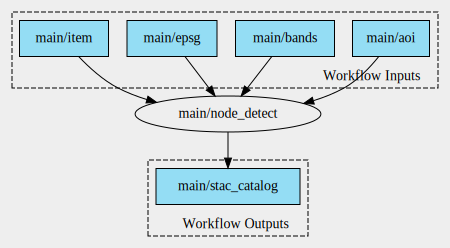

In [2]:
parsed_args = argparse.Namespace(print_dot=True, workflow="cwl-workflow/app-water-bodies.cwl#main", enable_ext=True)

stream_out = StringIO()
stream_err = StringIO()

res = cwltool_main(
    args=parsed_args,
    stdout=stream_out,
)
assert res == 0
graphviz.Source(stream_out.getvalue())

This Application Package has a parameter, `main/item` of type `Directory`:

In [6]:
def read_cwl_file(cwl_file_path):

    yaml = YAML(typ="safe")
    
    # Load the CWL document
    with open(cwl_file_path, 'r') as file:
        cwl_data = yaml.load(file)
        cwl_obj = load_document_by_yaml(cwl_data, "io://")

    return cwl_obj

def get_inputs(cwl_file_path):
    
    cwl_obj = read_cwl_file(cwl_file_path)

    # Collect inputs details
    inputs_data = []
    for input in cwl_obj.inputs:
        input_data = {
            "ID": input.id,
            "Type": input.type_,
            "Doc": input.doc if input.doc else "N/A",
            "Label": input.label if input.label else "N/A"
            
        }
        inputs_data.append(input_data)
    
    # Create DataFrame
    df = pd.DataFrame(inputs_data)
    return df

def get_outputs(cwl_file_path):
    
    cwl_obj = read_cwl_file(cwl_file_path)
    
    # Collect outputs details
    outputs_data = []
    for output in cwl_obj.outputs:
        output_data = {
            "ID": output.id,
            "Doc": output.doc if output.doc else "N/A",
            "Label": output.label if output.label else "N/A",
            "Type": output.type_
        }
        outputs_data.append(output_data)
    
    # Create DataFrame
    df = pd.DataFrame(outputs_data)
    return df


In [7]:

cwl_file = "cwl-workflow/app-water-bodies.cwl"

# Display the DataFrame as a table
display(get_inputs(cwl_file))

,ID,Type,Doc,Label
0,io:/#main/aoi,string,area of interest as a bounding box,area of interest
1,io:/#main/bands,<cwl_utils.parser.cwl_v1_0.InputArraySchema ob...,bands used for the NDWI,bands used for the NDWI
2,io:/#main/epsg,string,EPSG code,EPSG code
3,io:/#main/item,Directory,Staged Landsat-9 acquisition as a STAC Catalog,Staged Landsat-9 acquisition


And we inspect the outputs:

In [8]:
display(get_outputs(cwl_file))

,ID,Doc,Label,Type
0,io:/#main/stac_catalog,N/A,N/A,Directory


Let's wrap this Application Package using EOEPCA's cwl-wrapper utility.

The cwl-wrapper utility requires a few templates. 

We'll look at the `cwl-wrapper/conf/stage-in.cwl` and `cwl-wrapper/conf/stage-out.cwl` as these control the stage-in and stage-out. 

In [75]:
display(get_inputs("cwl-wrapper/conf/stage-in.cwl"))

""


In [76]:
display(get_outputs("cwl-wrapper/conf/stage-in.cwl"))

""


In [77]:
display(get_inputs("cwl-wrapper/conf/stage-out.cwl"))

,ID,Type,Doc,Label
0,io:/#stage-out/aws_access_key_id,string,N/A,N/A
1,io:/#stage-out/aws_secret_access_key,string,N/A,N/A
2,io:/#stage-out/endpoint_url,string,N/A,N/A
3,io:/#stage-out/region_name,string,N/A,N/A
4,io:/#stage-out/s3_bucket,string,N/A,N/A
5,io:/#stage-out/sub_path,string,N/A,N/A


In [78]:
display(get_outputs("cwl-wrapper/conf/stage-out.cwl"))

,ID,Doc,Label,Type
0,io:/#stage-out/s3_catalog_output,N/A,N/A,string


Now let's invoke cwl-wrapper with this configuration:

In [82]:

runner = CliRunner()
result = runner.invoke(cwl_wrapper_main, ['--help'])

print(result.output)

Usage: main [OPTIONS] CWL

  The cwl-parser

Options:
  --output TEXT       default main cel template assets/maincwl.yaml
  --stagein TEXT      default stagein template assets/stagein.yaml
  --stageout TEXT     default "stageout" template assets/stageout.yaml
  --maincwl TEXT      default maincwl assets/maincwl.yaml
  --rulez TEXT        rules default file assets/rules.yaml
  --assets TEXT       use <value> as maincwl from assets/<values>
  --workflow-id TEXT  workflow id
  -c, --conf FILE     Read options from FILE instead of command line; default
                      file: /home/jovyan/.cwlwrapper/default.conf
  --help              Show this message and exit.



In [83]:
arguments = ["--maincwl", "cwl-wrapper/conf/main.yaml",
             "--rulez", "cwl-wrapper/conf/rules.yaml", 
             "--stagein", "cwl-wrapper/conf/stage-in.cwl", 
             "--stageout", "cwl-wrapper/conf/stage-out.cwl",
             "cwl-workflow/app-water-bodies.cwl"]

runner = CliRunner()
result = runner.invoke(cwl_wrapper_main, args=arguments)

print(result.output)

$graph:
- $namespaces:
    cwltool: http://commonwl.org/cwltool#
  class: Workflow
  doc: Main stage manager
  hints:
    cwltool:Secrets:
      secrets: []
  id: wrapped
  inputs:
    aoi:
      doc: area of interest as a bounding box
      id: aoi
      label: area of interest
      type: string
    aws_access_key_id:
      type: string
    aws_secret_access_key:
      type: string
    bands:
      default:
      - green
      - nir
      doc: bands used for the NDWI
      id: bands
      label: bands used for the NDWI
      type: string[]
    endpoint_url:
      type: string
    epsg:
      default: EPSG:4326
      doc: EPSG code
      id: epsg
      label: EPSG code
      type: string
    item:
      doc: Staged Landsat-9 acquisition as a STAC Catalog
      id: item
      label: Staged Landsat-9 acquisition
      type: string
    region_name:
      type: string
    s3_bucket:
      type: string
    sub_path:
      type: string
  label: macro-cwl
  outputs:
    s3_catalog_output:
  

In [84]:
# save the output to a file
with open("w.cwl", "w") as f:
    f.write(result.output)

INFO /opt/conda/envs/env_stac/lib/python3.11/site-packages/ipykernel_launcher.py 3.1.20240909164951
INFO Resolved 'w.cwl#wrapped' to 'file:///workspaces/stac-eoap/notebooks/w.cwl#wrapped'


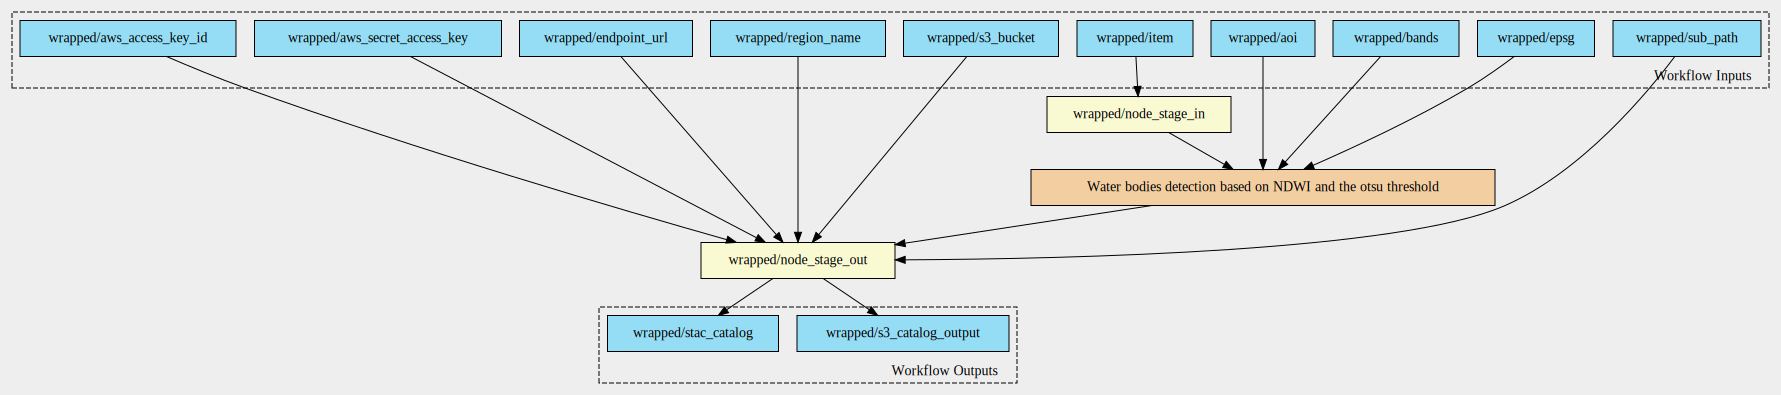

In [85]:
parsed_args = argparse.Namespace(print_dot=True, workflow="w.cwl#wrapped", enable_ext=True)

stream_out = StringIO()
stream_err = StringIO()

res = cwltool_main(
    args=parsed_args,
    stdout=stream_out,
)
assert res == 0
graphviz.Source(stream_out.getvalue())

**What happened?**

The wrapped CWL Workflow includes two additional steps:
* `wrapped/node_stage_in` that:
    * reads the `wrapped/item` parameter that is now a `string` (reference to a Landsat-9 acquisition catalog entry)
    * stages the Landsat-9 acquisition catalog entry as a STAC catalog
    * passes the resulting `Directory` to the `Water bodies detection based on NDWU and the otsu threshold` Workflow step
* `wrapped/node_stage_out` that:
    * reads the stage-out parameters:
        * `wrapped/aws_access_key_id`: the Platform AWS access key for the target S3 bucket
        * `wrapped/aws_secret_access_id`: the Platform AWS secret access key for the target S3 bucket
        * `wrapped/endpoint_url`: the  Platform S3 object storage service URL
        * `wrapped/region_name`: the Platorm S3 object storage region
        * `wrapped/bucket`: the Platorm S3 object storage bucket for the results
        * `wrapped/sub_path`: the Platorm S3 object storage bucket for the results
    * reads the `Water bodies detection based on NDWU and the otsu threshold` Workflow step results (type `Directory`)
    * pushes the STAC Catalog to S3
    * produces as output the `S3 catalog.json` URL (and `Water bodies detection based on NDWU and the otsu threshold` `stac_catalog` result)

### Running the wrapped 

At runtime, the Platform provides the additional parameters `aws_access_key_id`, `aws_secret_access_key`, `endpoint_url`, `s3_bucket`, `sub_path` and `region_name`.

Instead the Platform user selects the parameters `item` as a reference to a Landsat-9 acquisition catalog entry and the remaining Application Package input parameters `aoi` and `band`.

It is up to the Plaform to ensure the stage-in and stage-out steps parameters are managed.   

In [30]:
arguments = {"item": "https://planetarycomputer.microsoft.com/api/stac/v1/collections/landsat-c2-l2/items/LC09_L2SP_042033_20231015_02_T1",
             "aoi": "-118.985,38.432,-118.183,38.938",
             "band": ["green", "nir08"], 
             "aws_access_key_id": "test", 
             "aws_secret_access_key": "test",
             "endpoint_url": "http://localstack:4566", 
                "s3_bucket": "results",
                 "sub_path": "run-005", 
                 "region_name": "us-east-1"}

# create the YAML parameter file
with open("params.yaml", "w") as f:
    f.write(yaml.dump(arguments))

In [ ]:
parsed_args = argparse.Namespace(workflow="w.cwl#wrapped", enable_ext=True, job_order=["params.yaml"],)

stream_out = StringIO()
stream_err = StringIO()

res = cwltool_main(
    args=parsed_args,
    stdout=stream_out,
    stderr=stream_err,
)
assert res == 0

In [ ]:
stream_err.getvalue()

In [ ]:
stream_out.getvalue()

## Extra - Using cwl-wrapper Python API

In [17]:
workflow_id = "main"

wf = Parser(
    cwl="cwl-workflow/app-water-bodies.cwl",
    output=None,
    stagein="cwl-wrapper/conf/stage-in.cwl",
    stageout="cwl-wrapper/conf/stage-out.cwl",
    maincwl="cwl-wrapper/conf/main.yaml",
    rulez="cwl-wrapper/conf/rules.yaml",
    assets=None,
    workflow_id=workflow_id,
)

In [ ]:
wf.out